In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
import seaborn as sns


In [65]:
# Load data
df = pd.read_csv("ecommerce_furniture_dataset_2024.csv")  # Replace with actual dataset

In [66]:
df.head(7)

,productTitle,originalPrice,price,sold,tagText
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,NaN,$46.79,600,Free shipping
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,NaN,$169.72,0,Free shipping
2,Desser For Bedroom With 7 Fabric Drawers Organ...,$78.4,$39.46,7,Free shipping
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",NaN,$111.99,0,Free shipping
4,Small Unit Simple Computer Desk Household Wood...,$48.82,$21.37,1,Free shipping
5,"3 Pieces Patio Furniture Set, Outdoor Swivel G...","$1,294.04",$123.4,53,Free shipping
6,5-Piece Patio Furniture Set Outdoor Couch with...,NaN,$198.31,1,Free shipping


In [67]:
df.isnull().sum()

productTitle        0
originalPrice    1513
price               0
sold                0
tagText             3
dtype: int64

In [68]:
df.head(3)

,productTitle,originalPrice,price,sold,tagText
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,NaN,$46.79,600,Free shipping
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,NaN,$169.72,0,Free shipping
2,Desser For Bedroom With 7 Fabric Drawers Organ...,$78.4,$39.46,7,Free shipping


In [70]:
# Convert price columns to numeric
df['originalPrice'] = df['originalPrice'].astype(str).str.replace(r'[$,]', '', regex=True)
df['originalPrice'] = pd.to_numeric(df['originalPrice'], errors='coerce')
df['originalPrice'].fillna(df['originalPrice'].median(), inplace=True)
df['price'] = df['price'].astype(str).str.replace(r'[$,]', '', regex=True)
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['price'].fillna(df['price'].median(), inplace=True)

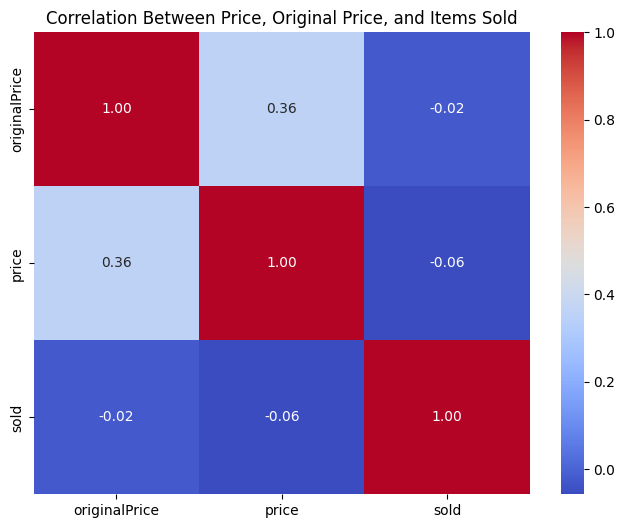

In [7]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[['originalPrice', 'price', 'sold']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Price, Original Price, and Items Sold")
plt.show()


# Distribution of Sales (Sold Items)

In [56]:
# This will show the skewness of sold values before and after applying log transformation.

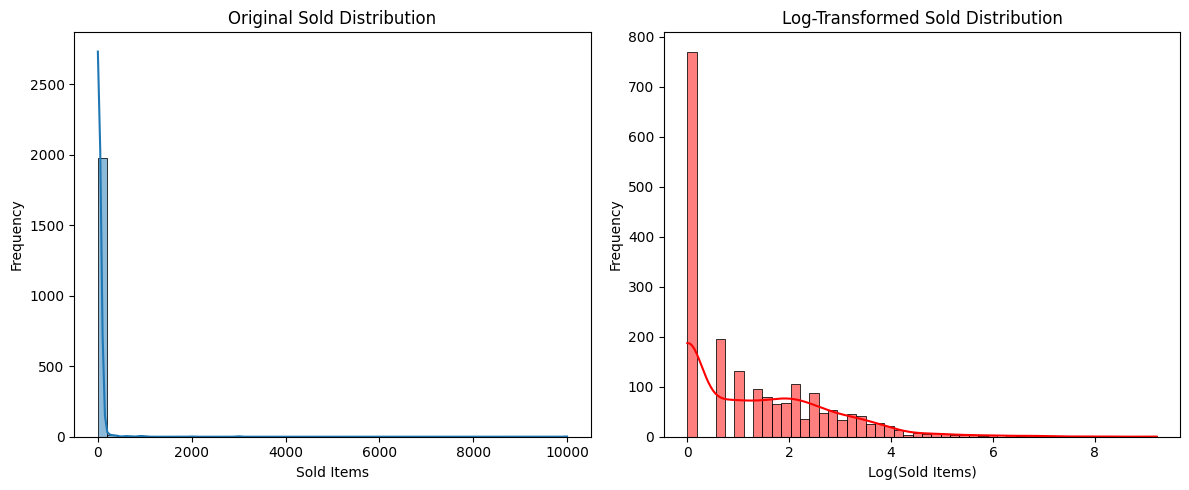

In [55]:
plt.figure(figsize=(12, 5))

# Original Sales Distribution
plt.subplot(1, 2, 1)
sns.histplot(df['sold'], bins=50, kde=True)
plt.title('Original Sold Distribution')
plt.xlabel('Sold Items')
plt.ylabel('Frequency')

# Log-transformed Sales Distribution
plt.subplot(1, 2, 2)
sns.histplot(df['log_sold'], bins=50, kde=True, color='red')
plt.title('Log-Transformed Sold Distribution')
plt.xlabel('Log(Sold Items)')
plt.ylabel('Frequency')

plt.savefig("Log-Transformed Sold Distribution.png", dpi = 1500 , bbox_inches='tight')

plt.tight_layout()
plt.show()


# Relationship Between Price, Discount, and Sales

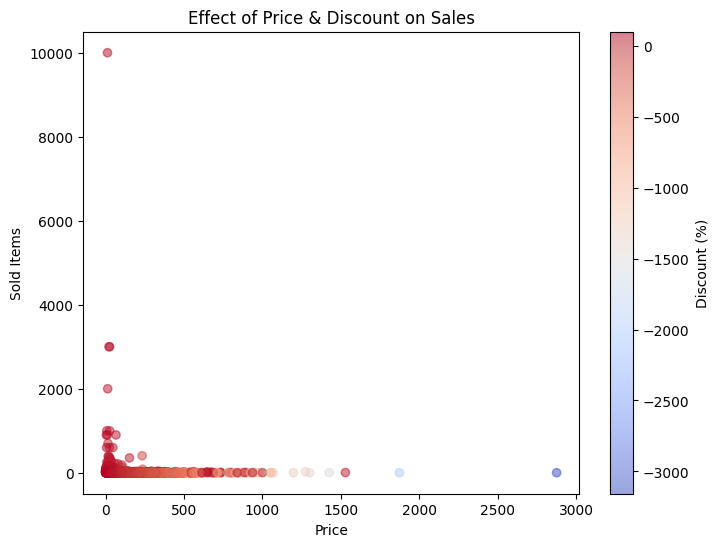

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['price'], df['sold'], c=df['discount'], cmap="coolwarm", alpha=0.5)

plt.colorbar(scatter, label="Discount (%)")  # Explicitly create a colorbar
plt.title("Effect of Price & Discount on Sales")
plt.xlabel("Price")
plt.ylabel("Sold Items")

plt.savefig("Effect of Price & Discount on Sales.png", dpi = 1500 , bbox_inches='tight')

plt.show()


# Model Performance Comparison (Bar Chart)

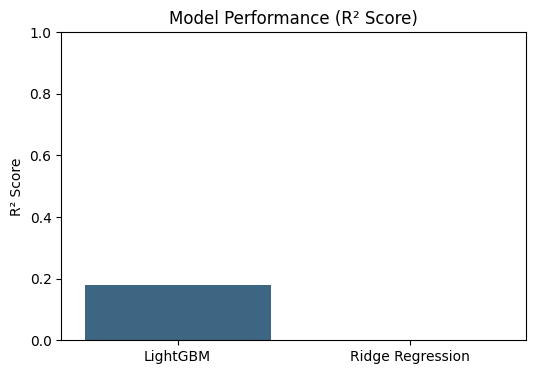

In [61]:
import numpy as np

# Data for models
models = ["LightGBM", "Ridge Regression"]
r2_scores = [r2_lgb, r2_ridge]

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=models, y=r2_scores, palette="viridis")
plt.title("Model Performance (R² Score)")
plt.ylabel("R² Score")
plt.ylim(0, 1)  # R² Score ranges from 0 to 1

plt.savefig("Model Performance (R² Score).png", dpi = 1500 , bbox_inches='tight')
plt.show()


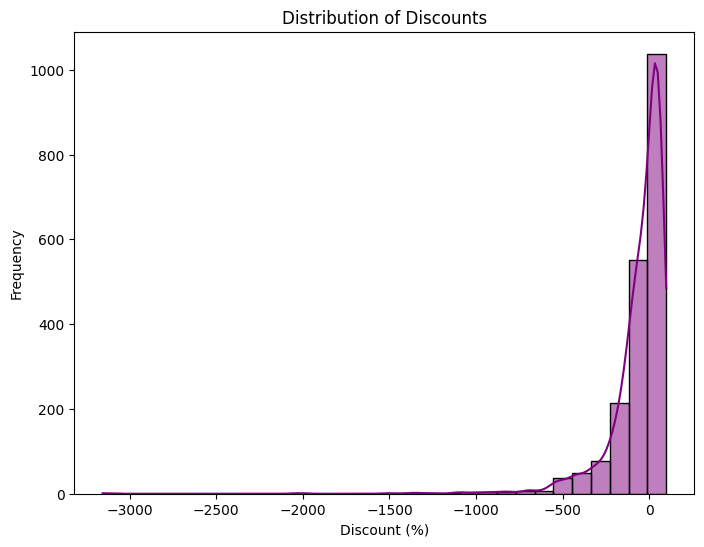

In [62]:
plt.figure(figsize=(8, 6))
sns.histplot(df['discount'], bins=30, kde=True, color="purple")
plt.title("Distribution of Discounts")
plt.xlabel("Discount (%)")
plt.ylabel("Frequency")

plt.savefig("Distribution of Discounts.png", dpi = 1500 , bbox_inches='tight')

plt.show()


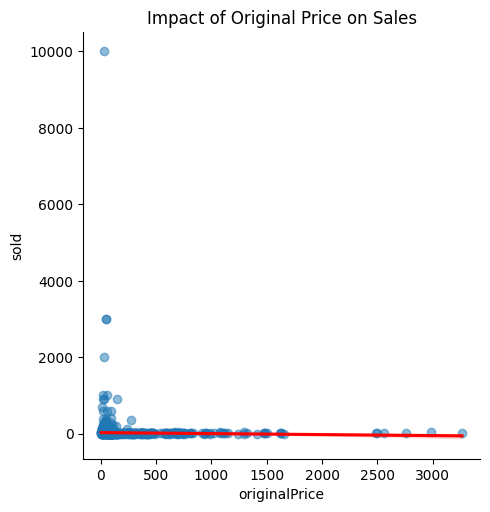

In [63]:
sns.lmplot(x='originalPrice', y='sold', data=df, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title("Impact of Original Price on Sales")

plt.savefig("Impact of Original Price on Sales.png", dpi = 1500 , bbox_inches='tight')

plt.show()


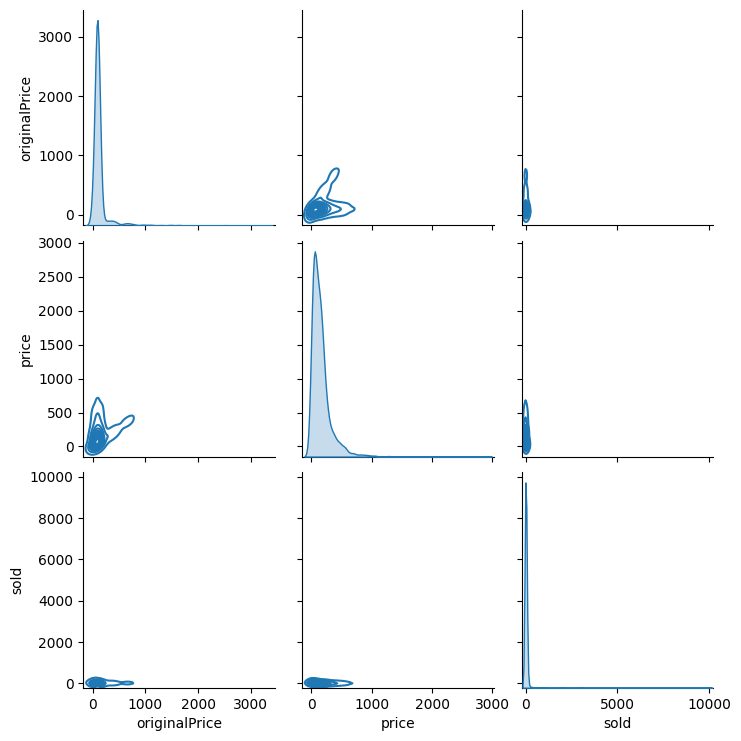

In [71]:
sns.pairplot(df, vars=['originalPrice', 'price', 'sold'], kind='kde')
plt.show()


In [13]:
df.fillna(0, inplace=True)  # Replace NaNs with 0 in all columns  # Handle missing values

In [14]:
df['tagText'].ffill(inplace=True)

In [15]:
df.isnull().sum()

productTitle     0
originalPrice    0
price            0
sold             0
tagText          0
dtype: int64

In [16]:
df['sold'].dtype


dtype('int64')

In [17]:
df.head(3)


,productTitle,originalPrice,price,sold,tagText
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,88.31,46.79,600,Free shipping
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,88.31,169.72,0,Free shipping
2,Desser For Bedroom With 7 Fabric Drawers Organ...,78.40,39.46,7,Free shipping


In [18]:
# Feature Engineering
df['discount'] = np.where(df['originalPrice'] > 0, (df['originalPrice'] - df['price']) / df['originalPrice'] * 100, 0)
df['price_diff'] = df['originalPrice'] - df['price']
df['sold'] = df['sold'].clip(lower=0)  # Prevent negative values
df['sold'] = df['sold'].clip(lower=1)  # Ensure no zeros before log
df['log_sold'] = np.log(df['sold'])  # Apply log transformation to handle skewness

In [19]:
tfidf = TfidfVectorizer(max_features=100)
df['productTitle'] = df['productTitle'].fillna("").astype(str)
df['tagText'] = df['tagText'].fillna("").astype(str)
title_features = tfidf.fit_transform(df['productTitle'] + " " + df['tagText']).toarray()
title_df = pd.DataFrame(title_features, columns=[f'title_{i}' for i in range(title_features.shape[1])])

In [20]:
# Combine features
X = pd.concat([df[['originalPrice', 'price', 'discount', 'price_diff']], title_df], axis=1)
X.replace([np.inf, -np.inf], np.nan, inplace=True)  # Convert inf → NaN
X.fillna(0, inplace=True)  # Replace NaNs with 0
y = df['log_sold']

In [21]:
X.head(3)

,originalPrice,price,discount,price_diff,title_0,title_1,title_2,title_3,title_4,title_5,...,title_90,title_91,title_92,title_93,title_94,title_95,title_96,title_97,title_98,title_99
0,88.31,46.79,47.016193,41.52,0.0,0.0,0.0,0.188505,0.0,0.0,...,0.0,0.0,0.0,0.0,0.298684,0.0,0.000000,0.119411,0.0,0.0
1,88.31,169.72,-92.186615,-81.41,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.297686,0.000000,0.0,0.0
2,78.40,39.46,49.668367,38.94,0.0,0.0,0.0,0.199036,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.126083,0.0,0.0


In [22]:
y.head(3)

0    6.39693
1    0.00000
2    1.94591
Name: log_sold, dtype: float64

In [23]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Scale numerical features
scaler = StandardScaler()
X_train[['originalPrice', 'price', 'discount']] = scaler.fit_transform(X_train[['originalPrice', 'price', 'discount']])
X_test[['originalPrice', 'price', 'discount']] = scaler.transform(X_test[['originalPrice', 'price', 'discount']])

In [25]:
# Train RandomForest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [26]:
model.score(X_test,y_test)

0.3574845737405754

In [27]:
# Predictions
y_pred = model.predict(X_test)


In [28]:
# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


In [29]:
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R² Score: {r2}")

MAE: 0.9092094784435666
MSE: 1.351209897875491
R² Score: 0.3574845737405754


In [30]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor

In [31]:
# Model with Hyperparameter Tuning
param_grid = {
    'max_iter': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

In [32]:
model = RandomizedSearchCV(HistGradientBoostingRegressor(random_state=42), param_grid, cv=3, n_iter=5, n_jobs=-1)
model.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=HistGradientBoostingRegressor(random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'max_iter': [100, 200, 300]})

In [33]:
model.score(X_test,y_test)

0.3462320884079084

In [34]:
# Predictions
y_pred = model.predict(X_test)

In [35]:
# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [36]:
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R² Score: {r2}")

MAE: 0.9537677827822758
MSE: 1.3748738737674244
R² Score: 0.3462320884079084


# Ridge Model

In [37]:
from sklearn.linear_model import Ridge
import lightgbm as lgb

In [38]:
X.isnull().sum()

originalPrice    0
price            0
discount         0
price_diff       0
title_0          0
                ..
title_95         0
title_96         0
title_97         0
title_98         0
title_99         0
Length: 104, dtype: int64

In [39]:
df.head(3)

,productTitle,originalPrice,price,sold,tagText,discount,price_diff,log_sold
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,88.31,46.79,600,Free shipping,47.016193,41.52,6.39693
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,88.31,169.72,1,Free shipping,-92.186615,-81.41,0.00000
2,Desser For Bedroom With 7 Fabric Drawers Organ...,78.40,39.46,7,Free shipping,49.668367,38.94,1.94591


In [40]:
# Scale numerical features
scaler = StandardScaler()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test = scaler.transform(X_test)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [41]:
# Train LightGBM Model
lgb_model = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=7, random_state=42)
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6361
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 104
[LightGBM] [Info] Start training from score 1.293870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

LGBMRegressor(learning_rate=0.05, max_depth=7, n_estimators=200,
              random_state=42)

In [42]:
# Train Linear Regression as Baseline
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

Ridge()

In [43]:
# Predictions
y_pred_lgb = lgb_model.predict(X_test)
y_pred_ridge = ridge.predict(X_test)

In [44]:
# Convert back from log scale
# Replace NaN and infinite values in predictions and actual values
y_test_actual = np.expm1(y_test)  # Convert back from log scale
y_pred_lgb = np.nan_to_num(y_pred_lgb, nan=0, posinf=0, neginf=0)
y_pred_ridge = np.nan_to_num(y_pred_ridge, nan=np.median(y_pred_ridge), posinf=np.median(y_pred_ridge), neginf=0)
y_pred_lgb = np.expm1(y_pred_lgb)
y_pred_ridge = np.expm1(y_pred_ridge)
y_test_actual = np.expm1(y_test)

In [45]:
# Evaluate Models
mae_lgb = mean_absolute_error(y_test_actual, y_pred_lgb)
mse_lgb = mean_squared_error(y_test_actual, y_pred_lgb)
r2_lgb = r2_score(y_test_actual, y_pred_lgb)

In [46]:
mae_ridge = mean_absolute_error(y_test_actual, y_pred_ridge)
mse_ridge = mean_squared_error(y_test_actual, y_pred_ridge)
r2_ridge = r2_score(y_test_actual, y_pred_ridge)

In [47]:
print("LightGBM Performance:")
print(f"MAE: {mae_lgb}")
print(f"MSE: {mse_lgb}")
print(f"R² Score: {r2_lgb}")

LightGBM Performance:
MAE: 16.348093665763
MSE: 4497.1314986386615
R² Score: 0.17873421768178854


In [48]:
print("\nRidge Regression Performance:")
print(f"MAE: {mae_ridge}")
print(f"MSE: {mse_ridge}")
print(f"R² Score: {r2_ridge}")



Ridge Regression Performance:
MAE: 48915457300.68174
MSE: 8.375423266293759e+23
R² Score: -1.529519104149186e+20


# LinearRegression

In [49]:
from sklearn.linear_model import LinearRegression


In [50]:
# Initialize models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100,random_state=42)

In [51]:
# Train models
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [52]:
# Predict with Linear Regression
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

In [53]:
# Predict with Random Forest
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

In [54]:
# Print model evaluation results
print(f'Linear Regression MSE: {mse_lr}, R2: {r2_lr}')
print(f'Random Forest MSE: {mse_rf}, R2: {r2_rf}')

Linear Regression MSE: 46.20280704389724, R2: -20.969951751291152
Random Forest MSE: 2.3485647314727265, R2: -0.11676880987375493


In [72]:
# Display the first 5 rows of the transformed TF-IDF matrix
tfidf_sample = pd.DataFrame(title_features[:5], columns=[f'title_{i}' for i in range(title_features.shape[1])])
print(tfidf_sample)


   title_0  title_1  title_2   title_3  title_4  title_5  title_6   title_7  \
0      0.0      0.0      0.0  0.188505      0.0      0.0      0.0  0.242027   
1      0.0      0.0      0.0  0.000000      0.0      0.0      0.0  0.000000   
2      0.0      0.0      0.0  0.199036      0.0      0.0      0.0  0.255548   
3      0.0      0.0      0.0  0.000000      0.0      0.0      0.0  0.000000   
4      0.0      0.0      0.0  0.000000      0.0      0.0      0.0  0.000000   

   title_8   title_9  ...  title_90  title_91  title_92  title_93  title_94  \
0      0.0  0.000000  ...       0.0  0.000000       0.0       0.0  0.298684   
1      0.0  0.241036  ...       0.0  0.000000       0.0       0.0  0.000000   
2      0.0  0.000000  ...       0.0  0.000000       0.0       0.0  0.000000   
3      0.0  0.541409  ...       0.0  0.366449       0.0       0.0  0.000000   
4      0.0  0.000000  ...       0.0  0.000000       0.0       0.0  0.000000   

   title_95  title_96  title_97  title_98  title_9

In [73]:
# Get top 10 important words
feature_names = tfidf.get_feature_names_out()
print("Top 10 words in TF-IDF:", feature_names[:10])


Top 10 words in TF-IDF: ['adjustable' 'and' 'bed' 'bedroom' 'bedside' 'bench' 'black' 'cabinet'
 'cabinets' 'chair']


In [74]:
sample_index = 0  # Choose a row to check
feature_array = title_features[sample_index]  # Get TF-IDF values for one row
word_importance = {word: feature_array[i] for i, word in enumerate(feature_names)}
sorted_words = sorted(word_importance.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 most important words for this product:", sorted_words)


Top 10 most important words for this product: [('clothes', np.float64(0.3393778927684777)), ('steel', np.float64(0.32875166109411785)), ('for', np.float64(0.31474469216812073)), ('wardrobe', np.float64(0.29868375276026576)), ('closet', np.float64(0.28289728544174675)), ('fabric', np.float64(0.28019840487777015)), ('frame', np.float64(0.27606675680071957)), ('of', np.float64(0.2602054223569112)), ('dresser', np.float64(0.2531596549435048)), ('cabinet', np.float64(0.242026618342115))]


In [75]:
# Convert TF-IDF transformed data to a DataFrame
tfidf_df = pd.DataFrame(title_features, columns=[f'title_{i}' for i in range(title_features.shape[1])])

# Save as CSV
tfidf_df.to_csv("tfidf_transformed_data.csv", index=False)
print("TF-IDF data saved as CSV!")


TF-IDF data saved as CSV!


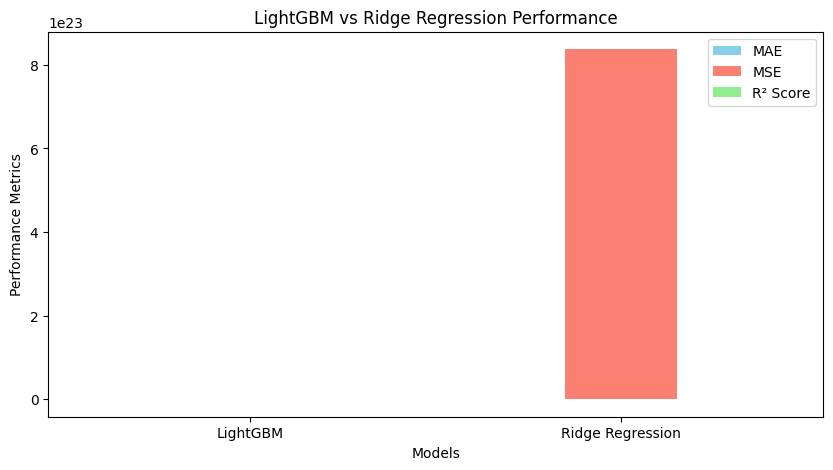

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Model performance metrics
models = ['LightGBM', 'Ridge Regression']
mae_values = [mae_lgb, mae_ridge]
mse_values = [mse_lgb, mse_ridge]
r2_values = [r2_lgb, r2_ridge]

# Set up the bar chart
x = np.arange(len(models))  # X-axis positions
width = 0.3  # Bar width

fig, ax = plt.subplots(figsize=(10, 5))

# Plot bars
bar1 = ax.bar(x - width, mae_values, width, label='MAE', color='skyblue')
bar2 = ax.bar(x, mse_values, width, label='MSE', color='salmon')
bar3 = ax.bar(x + width, r2_values, width, label='R² Score', color='lightgreen')

# Labels and title
ax.set_xlabel("Models")
ax.set_ylabel("Performance Metrics")
ax.set_title("LightGBM vs Ridge Regression Performance")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Display the chart
plt.savefig("model_comparison_chart.png", dpi=1500)  # Save for PPT
plt.show()
